### Problem 2)
##### A team of plantation planners are concerned about the yield of oil palm trees, which seems to fluctuate. They have collected a set of data and needed help in analysing on how external factors influence fresh fruit bunch (FFB) yield. Some experts are of opinion that the flowering of oil palm tree determines the FFB yield, and are linked to the external factors. Perform the analysis, which requires some study on the background of oil palm tree physiology.

This question asks for an analysis to be done on how external factors influence the fresh fruit bunch yield of oil palm trees. The dataset given to answer this question contains variables with data points taken sequentially over time. The variables are: the moisture of the soil, the average temperature, the minimum temperature, the maximum temperature, the precipitation, the number of working days, the area of land harvested in hectares, and the fresh fruit bunch yield of the oil palm trees. The dataset given is a time-series.

An analysis on how external factors influence the yield of oil palm trees falls under the study of econometrics. Econometrics is the use of statistics to analyze data to answer economic questions and estimate statistical relationships. I want to know what the yield of oil palm trees is a function of. I want to create a model of oil palm tree yield. I will assume a linear functional form for my yield model, where yield is a linear function of other variables. My model will be a good one if it can describe real data, in this case, actually describe yield patterns and how certain factors influence it.


I will run a multivariate Ordinary Least Squares (OLS) regression, which will calculate my coefficients (i.e. how much the independent variables are correlated with the yield) by minimizing the sum of squared residuals. There are 6 assumptions that need to hold in order for my coefficients found using OLS to be best linear unbiased estimators of the true coefficients. They are: 1) conditional mean independence, 2) the error term has constant variance, 3) no perfect multicollinearity, 4) observations of the error term are uncorrelated with each other, 5) the error term has zero population mean, and 6) the error term is normally distributed.

Throughout this notebook, I will show how my assumptions hold or do not hold. Towards the end, I will conclude that all my assumptions hold, except for the first assumption. My final conclusion is that the following external factors have a statistically significant relationship with the yield of oil palm trees based on my regression model: the precipitation and the number of working days.

# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# Exploratory Data Analysis

In [2]:
data = pd.read_csv('palm_ffb.csv')
data.head()
# As can be seen in the 'Date' column, the data was collected on a monthly basis

,Date,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
0,01.01.2008,616.4,25.306452,21.3,32.2,184.4,25,777778.3951,1.62
1,01.02.2008,568.9,26.165517,20.9,35.1,140.2,23,767988.2759,1.45
2,01.03.2008,577.6,25.448387,21.3,32.9,280.4,25,783951.9231,1.56
3,01.04.2008,581.1,26.903333,20.6,34.8,173.3,25,788987.0504,1.39
4,01.05.2008,545.4,27.241935,20.9,35.0,140.6,25,813659.7222,1.44


In [3]:
data.describe()
# This helps us have an overview of the dataset at hand.

,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,527.646923,26.849918,21.379231,33.851538,188.980769,24.753846,793404.491565,1.602231
std,57.367844,0.651413,0.688971,1.079638,80.237210,1.239289,34440.893854,0.281751
min,380.700000,25.158065,18.900000,31.100000,2.000000,21.000000,683431.944400,1.080000
25%,488.625000,26.442285,21.000000,33.100000,140.300000,24.000000,768966.949100,1.390000
50%,538.300000,26.930645,21.500000,33.900000,182.150000,25.000000,790036.158050,1.585000
75%,571.025000,27.270726,21.800000,34.600000,226.100000,26.000000,821989.235250,1.807500
max,647.300000,28.580000,22.600000,36.000000,496.100000,27.000000,882254.225400,2.270000


In [4]:
# Check to see if the dataset contains any null values
data.isnull().sum()
# We do not have any null values

Date             0
SoilMoisture     0
Average_Temp     0
Min_Temp         0
Max_Temp         0
Precipitation    0
Working_days     0
HA_Harvested     0
FFB_Yield        0
dtype: int64

In [5]:
# Change the data in the 'Date' column into datetime objects, and then make the column the index of the dataset. This is important when
# working with time series. This also helps us to easily see the date as the x axis when plotting line graphs of each variable
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.set_index('Date')

In [6]:
data.corr()
# We see here that Average_Temp is highly correlated with Max_Temp. This is expected. 

,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
SoilMoisture,1.000000,-0.649878,0.015839,-0.499936,0.552001,-0.057015,-0.326539,-0.003183
Average_Temp,-0.649878,1.000000,0.180396,0.761083,-0.369386,0.076321,0.446515,-0.005494
Min_Temp,0.015839,0.180396,1.000000,-0.124754,0.345944,0.068414,0.024396,0.103830
Max_Temp,-0.499936,0.761083,-0.124754,1.000000,-0.461117,-0.039112,0.314827,-0.071201
Precipitation,0.552001,-0.369386,0.345944,-0.461117,1.000000,0.127897,-0.265866,0.289604
Working_days,-0.057015,0.076321,0.068414,-0.039112,0.127897,1.000000,0.048876,0.116364
HA_Harvested,-0.326539,0.446515,0.024396,0.314827,-0.265866,0.048876,1.000000,-0.350222
FFB_Yield,-0.003183,-0.005494,0.103830,-0.071201,0.289604,0.116364,-0.350222,1.000000


In [7]:
# We can go ahead and delete Max_Temp. We can delete Min_Temp as well as intuition tells us the Average_Temp variable already captures
# information from both Max_Temp and Min_Temp
data = data.drop(['Min_Temp', 'Max_Temp'], axis=1)

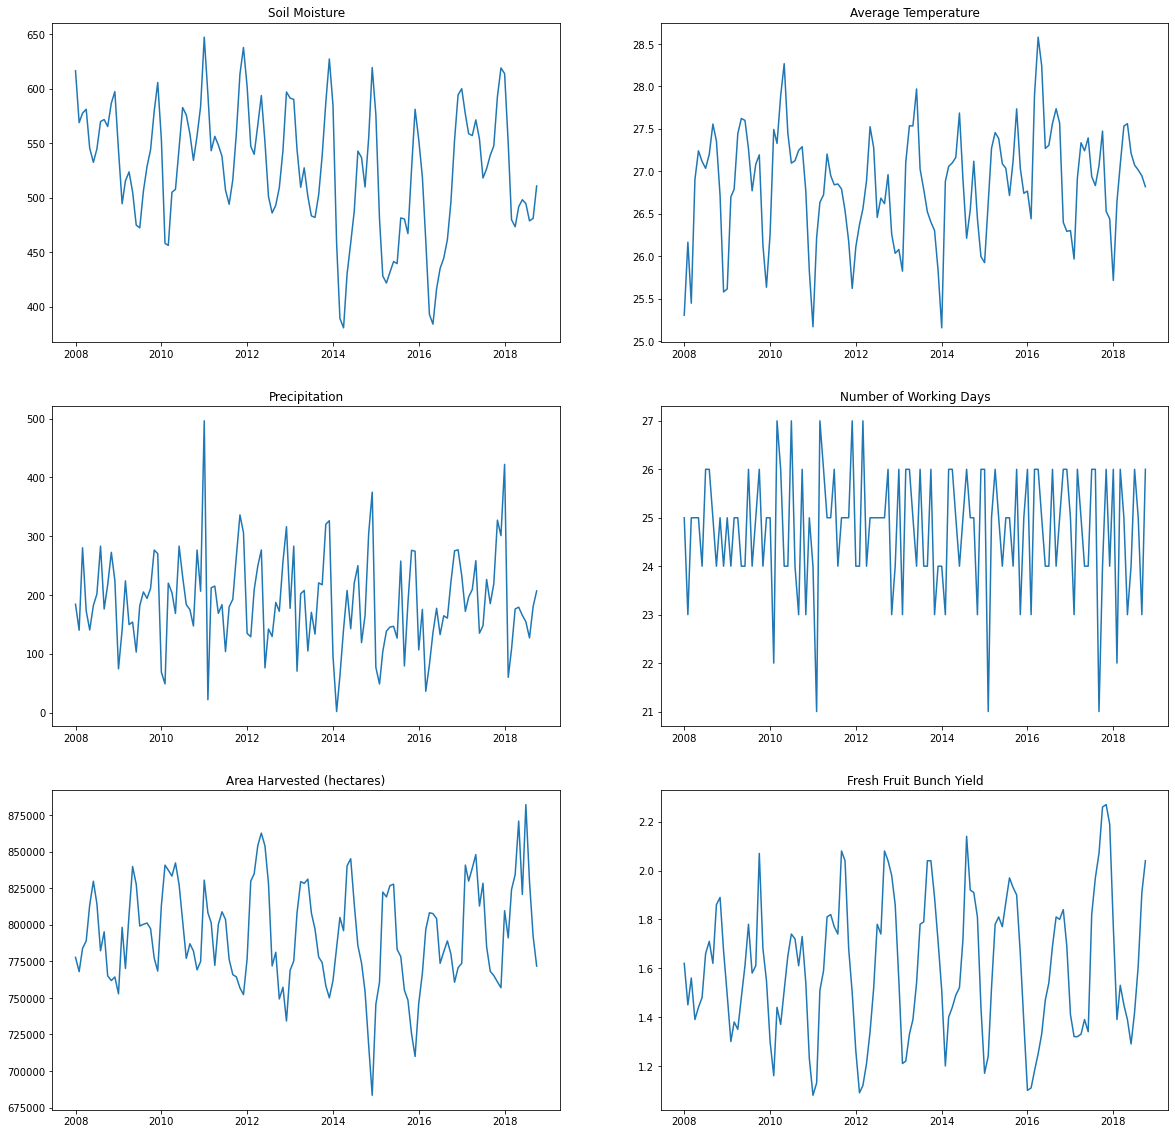

In [8]:
# Plot graphs for each variable to have a visual representation of each variable
fig, [(ax1, ax2), (ax3, ax4), (ax5, ax6)] = plt.subplots(3, 2, figsize=(20,20))
ax1.plot(data['SoilMoisture'])
ax1.set_title('Soil Moisture')
ax2.plot(data['Average_Temp'])
ax2.set_title('Average Temperature')
ax3.plot(data['Precipitation'])
ax3.set_title('Precipitation')
ax4.plot(data['Working_days'])
ax4.set_title('Number of Working Days')
ax5.plot(data['HA_Harvested'])
ax5.set_title('Area Harvested (hectares)')
ax6.plot(data['FFB_Yield'])
ax6.set_title('Fresh Fruit Bunch Yield')

plt.show()

# Data Preprocessing

In [9]:
# Test for stationarity for each variable. Stationarity is important if we want do create an OLS linear regression, as non-stationary time series
# does not have the property of independence, which is vital in order for the assumptions of OLS to hold.
for i in data.columns:
    print(i + ':' + ' ' + str(adfuller(data[i])[1]))
# Except for the yield dependent variable, all the other variables are not stationary

SoilMoisture: 0.22428012505393347
Average_Temp: 0.24149604455902285
Precipitation: 0.27634432968766687
Working_days: 0.07876624487484818
HA_Harvested: 0.3991531546880376
FFB_Yield: 0.044403989491318456


In [10]:
# do first order differencing to all the non stationary data in order to make them stationary
data['average_temp_diff'] = data['Average_Temp'].diff()
data['soil_moisture_diff'] = data['SoilMoisture'].diff()
data['precipitation_diff'] = data['Precipitation'].diff()
data['working_days_diff'] = data['Working_days'].diff()
data['ha_harvested_diff'] = data['HA_Harvested'].diff()

In [11]:
# Create a new dataframe containing the stationary data
data_stationary = data[['FFB_Yield', 'average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff']]

In [12]:
# Differencing caused the first observation to be NA for the independent variables. Hence, we remove the first observation
data_stationary = data_stationary.dropna()

In [13]:
# Confirm that all the variables are now stationary
for i in data_stationary.columns:
    print(i + ':' + ' ' + str(adfuller(data_stationary[i])[1]))

FFB_Yield: 0.0456669651329165
average_temp_diff: 0.012145090035188825
soil_moisture_diff: 5.165692797463842e-06
precipitation_diff: 3.4944887025900415e-12
working_days_diff: 1.320172641365229e-07
ha_harvested_diff: 2.0366274872187356e-13


In [14]:
# We put the independent variables into dataframe simply called X and my dependent variable into a series simply called Y
X = data_stationary[['average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff']]
Y = data_stationary['FFB_Yield']

In [15]:
# Test to see if the third assumption holds, i.e., test to see if we have a multicollinearity problem.
# One procedure to test for multicollinearity is to check the Variance Inflation Factors, which measures how much the correlation between
# independent variables increase the variance. If the VIF>10, then we have a multicollinearity problem. This will make the variance of the
# coefficients higher, which will make the t statistic smaller and the coefficient estimates imprecise, causing the potential for a coefficient
# to not be significant when it in fact is significant.

vif = pd.DataFrame()
vif['feature'] = X.columns
vif['VIF'] = ''
vif_list = []
for i in range(len(X.columns)):
    vif_list.append(variance_inflation_factor(X.values,i))
vif['VIF'] = vif_list
vif
# We have sufficient evidence to conclude that we do not have a multicollinearity problem

,feature,VIF
0,average_temp_diff,1.582581
1,soil_moisture_diff,1.700934
2,precipitation_diff,1.318014
3,working_days_diff,1.040065
4,ha_harvested_diff,1.132236


# Model Fitting

In [16]:
# Fit an OLS model and show the summary results
X1 = sm.add_constant(X)
reg = sm.OLS(Y, X1).fit()
reg.summary()
# My model has an adjusted R squared of 0.291. The adjusted R squared is a number between 0 and 1. It indicates how much of the dependent
# variable is explained by the independent variables. It increases only when a relevant variable is added to the model. An adjusted R Squared of
# 0.291 is not rather small.
# We also note the Durbin-Watson statistic. the Durbin–Watson statistic is a test statistic used to detect the presence of autocorrelation at
# lag 1 in the residuals. The closer it is to 2, the better. We get only 0.867, which indicates that we have a problem of autocorrelation in the
# residuals, which means that the fourth assumption, namely, that the observations of the error term are uncorrelated with each other, does not
# hold.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FFB_Yield   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     11.52
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           3.93e-09
Time:                        05:43:20   Log-Likelihood:                 5.1355
No. Observations:                 129   AIC:                             1.729
Df Residuals:                     123   BIC:                             18.89
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.6038      0.021     76.458      0.000       1.562       1.645
average_temp_diff     -0.0534      0.048     -1.119      0.265      -0.148       0.041
soil_moisture_diff     0.0017      0.001      2.259      0.026       0.000       0.003
precipitation_diff     0.0002      0.000      0.860      0.392      -0.000       0.001
working_days_diff      0.0114      0.011      1.057      0.293      -0.010       0.033
ha_harvested_diff  -3.907e-06   8.75e-07     -4.467      0.000   -5.64e-06   -2.18e-06
==============================================================================
Omnibus:                        0.313   Durbin-Watson:                   0.867
Prob(Omnibus):                  0.855   Jarque-Bera (JB):                0.404
Skew:                           0.112   Prob(JB):                        0.817
Kurtosis:                       2.842   Cond. No.                     5.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
# we add an autoregressive term with order one into the model to help solve for the autocorrelation problem in the residuals
data['FFB_Yield_shift_1'] = data['FFB_Yield'].shift(1)
data_stationary = data[['FFB_Yield', 'average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff', 'FFB_Yield_shift_1']]
data_stationary = data_stationary.dropna()

X = data_stationary[['average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff', 'FFB_Yield_shift_1']]
Y = data_stationary['FFB_Yield']

X1 = sm.add_constant(X)
reg = sm.OLS(Y, X1).fit()
reg.summary()
# I now have an adjusted r squared value of 0.680, which is better, and a durbin-watson statistic of 1.528, which is also better.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FFB_Yield   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     46.24
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           3.62e-29
Time:                        05:43:20   Log-Likelihood:                 56.870
No. Observations:                 129   AIC:                            -99.74
Df Residuals:                     122   BIC:                            -79.72
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4282      0.097      4.415      0.000       0.236       0.620
average_temp_diff      0.0035      0.032      0.109      0.913      -0.061       0.068
soil_moisture_diff    -0.0003      0.001     -0.643      0.521      -0.001       0.001
precipitation_diff     0.0005      0.000      2.942      0.004       0.000       0.001
working_days_diff      0.0195      0.007      2.670      0.009       0.005       0.034
ha_harvested_diff  -2.271e-06   6.03e-07     -3.765      0.000   -3.46e-06   -1.08e-06
FFB_Yield_shift_1      0.7338      0.060     12.251      0.000       0.615       0.852
==============================================================================
Omnibus:                        1.814   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.404   Jarque-Bera (JB):                1.416
Skew:                           0.073   Prob(JB):                        0.493
Kurtosis:                       3.492   Cond. No.                     2.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
# The durbon-watson statistic of 1.528 indicates that I might still have an autocorrelation problem in my residuals. I will use a ljung box
# test to check if this is the case
sm.stats.acorr_ljungbox(reg.resid, lags=[36], return_df=True)
# the null hypothesis is that there is no autocorrelation. I obtain a p-value of 1.363790e-24, so I have sufficient evidence to reject the null
# hypothesis and conclude that I do still have autocorrelation

,lb_stat,lb_pvalue
36,199.804132,1.363790e-24


In [19]:
# I add another autoregressive term, this time with order 2. I do this as long as my adjusted R squared values continue to increase and until my
# ljung box test shows that I do not have an autocorrelation problem in my residuals
data['FFB_Yield_shift_1'] = data['FFB_Yield'].shift(1)
data['FFB_Yield_shift_2'] = data['FFB_Yield'].shift(2)
data_stationary = data[['FFB_Yield', 'average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff', 'FFB_Yield_shift_1', 'FFB_Yield_shift_2']]
data_stationary = data_stationary.dropna()

X = data_stationary[['average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff', 'FFB_Yield_shift_1', 'FFB_Yield_shift_2']]
Y = data_stationary['FFB_Yield']

X1 = sm.add_constant(X)
reg = sm.OLS(Y, X1).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FFB_Yield   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     49.75
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           1.45e-32
Time:                        05:43:20   Log-Likelihood:                 67.303
No. Observations:                 128   AIC:                            -118.6
Df Residuals:                     120   BIC:                            -95.79
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4969      0.091      5.466      0.000       0.317       0.677
average_temp_diff     -0.0138      0.030     -0.453      0.651      -0.074       0.046
soil_moisture_diff    -0.0008      0.000     -1.528      0.129      -0.002       0.000
precipitation_diff     0.0004      0.000      2.518      0.013    7.92e-05       0.001
working_days_diff      0.0205      0.007      3.031      0.003       0.007       0.034
ha_harvested_diff  -1.381e-06   5.91e-07     -2.335      0.021   -2.55e-06    -2.1e-07
FFB_Yield_shift_1      1.0772      0.091     11.856      0.000       0.897       1.257
FFB_Yield_shift_2     -0.3863      0.082     -4.719      0.000      -0.548      -0.224
==============================================================================
Omnibus:                        6.272   Durbin-Watson:                   2.208
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                7.074
Skew:                           0.319   Prob(JB):                       0.0291
Kurtosis:                       3.958   Cond. No.                     2.34e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
sm.stats.acorr_ljungbox(reg.resid, lags=[36], return_df=True)
# There is still autocorrelation in my residuals

,lb_stat,lb_pvalue
36,90.283776,0.000001


In [21]:
# I add another autoregressive term, this time with order 3
data['FFB_Yield_shift_1'] = data['FFB_Yield'].shift(1)
data['FFB_Yield_shift_2'] = data['FFB_Yield'].shift(2)
data['FFB_Yield_shift_3'] = data['FFB_Yield'].shift(3)
data_stationary = data[['FFB_Yield', 'average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff', 'FFB_Yield_shift_1', 'FFB_Yield_shift_2', 'FFB_Yield_shift_3']]
data_stationary = data_stationary.dropna()

X = data_stationary[['average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff', 'FFB_Yield_shift_1', 'FFB_Yield_shift_2', 'FFB_Yield_shift_3']]
Y = data_stationary['FFB_Yield']

X1 = sm.add_constant(X)
reg = sm.OLS(Y, X1).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FFB_Yield   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     49.62
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           3.10e-34
Time:                        05:43:20   Log-Likelihood:                 73.399
No. Observations:                 127   AIC:                            -128.8
Df Residuals:                     118   BIC:                            -103.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6160      0.093      6.649      0.000       0.433       0.800
average_temp_diff     -0.0003      0.029     -0.009      0.993      -0.058       0.058
soil_moisture_diff    -0.0009      0.000     -1.959      0.052      -0.002    1.03e-05
precipitation_diff     0.0004      0.000      2.818      0.006       0.000       0.001
working_days_diff      0.0230      0.007      3.531      0.001       0.010       0.036
ha_harvested_diff  -1.232e-06   5.66e-07     -2.177      0.031   -2.35e-06   -1.11e-07
FFB_Yield_shift_1      0.9796      0.091     10.764      0.000       0.799       1.160
FFB_Yield_shift_2     -0.0580      0.118     -0.490      0.625      -0.292       0.176
FFB_Yield_shift_3     -0.3055      0.082     -3.722      0.000      -0.468      -0.143
==============================================================================
Omnibus:                       11.709   Durbin-Watson:                   2.141
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.255
Skew:                           0.467   Prob(JB):                     0.000179
Kurtosis:                       4.545   Cond. No.                     3.19e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
sm.stats.acorr_ljungbox(reg.resid, lags=[36], return_df=True)
# I still have an autocorrelation problem in my residuals

,lb_stat,lb_pvalue
36,58.470603,0.010344


In [23]:
# I add another autoregressive term, this time with order 4
data['FFB_Yield_shift_1'] = data['FFB_Yield'].shift(1)
data['FFB_Yield_shift_2'] = data['FFB_Yield'].shift(2)
data['FFB_Yield_shift_3'] = data['FFB_Yield'].shift(3)
data['FFB_Yield_shift_4'] = data['FFB_Yield'].shift(4)
data_stationary = data[['FFB_Yield', 'average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff', 'FFB_Yield_shift_1', 'FFB_Yield_shift_2', 'FFB_Yield_shift_3', 'FFB_Yield_shift_4']]
data_stationary = data_stationary.dropna()

X = data_stationary[['average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff', 'FFB_Yield_shift_1', 'FFB_Yield_shift_2', 'FFB_Yield_shift_3', 'FFB_Yield_shift_4']]
Y = data_stationary['FFB_Yield']

X1 = sm.add_constant(X)
reg = sm.OLS(Y, X1).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FFB_Yield   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     48.19
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           4.19e-35
Time:                        05:43:20   Log-Likelihood:                 77.796
No. Observations:                 126   AIC:                            -135.6
Df Residuals:                     116   BIC:                            -107.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7652      0.102      7.510      0.000       0.563       0.967
average_temp_diff      0.0235      0.030      0.787      0.433      -0.036       0.083
soil_moisture_diff    -0.0008      0.000     -1.683      0.095      -0.002       0.000
precipitation_diff     0.0004      0.000      3.124      0.002       0.000       0.001
working_days_diff      0.0212      0.006      3.352      0.001       0.009       0.034
ha_harvested_diff  -9.203e-07   5.55e-07     -1.657      0.100   -2.02e-06     1.8e-07
FFB_Yield_shift_1      0.9356      0.090     10.453      0.000       0.758       1.113
FFB_Yield_shift_2     -0.1051      0.115     -0.912      0.364      -0.333       0.123
FFB_Yield_shift_3     -0.0486      0.113     -0.428      0.669      -0.273       0.176
FFB_Yield_shift_4     -0.2581      0.083     -3.102      0.002      -0.423      -0.093
==============================================================================
Omnibus:                       12.804   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.707
Skew:                           0.643   Prob(JB):                     0.000640
Kurtosis:                       4.071   Cond. No.                     3.32e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
sm.stats.acorr_ljungbox(reg.resid, lags=[36], return_df=True)
# I still have an autocorrelation problem in my residuals

,lb_stat,lb_pvalue
36,51.894992,0.041968


In [25]:
# I add another autoregressive term, this time with order 5
data['FFB_Yield_shift_1'] = data['FFB_Yield'].shift(1)
data['FFB_Yield_shift_2'] = data['FFB_Yield'].shift(2)
data['FFB_Yield_shift_3'] = data['FFB_Yield'].shift(3)
data['FFB_Yield_shift_4'] = data['FFB_Yield'].shift(4)
data['FFB_Yield_shift_5'] = data['FFB_Yield'].shift(5)
data_stationary = data[['FFB_Yield', 'average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff', 'FFB_Yield_shift_1', 'FFB_Yield_shift_2', 'FFB_Yield_shift_3', 'FFB_Yield_shift_4', 'FFB_Yield_shift_5']]
data_stationary = data_stationary.dropna()

X = data_stationary[['average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff', 'FFB_Yield_shift_1', 'FFB_Yield_shift_2', 'FFB_Yield_shift_3', 'FFB_Yield_shift_4', 'FFB_Yield_shift_5']]
Y = data_stationary['FFB_Yield']

X1 = sm.add_constant(X)
reg = sm.OLS(Y, X1).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FFB_Yield   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     44.39
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           1.04e-34
Time:                        05:43:20   Log-Likelihood:                 78.860
No. Observations:                 125   AIC:                            -135.7
Df Residuals:                     114   BIC:                            -104.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9076      0.124      7.330      0.000       0.662       1.153
average_temp_diff      0.0305      0.030      1.025      0.307      -0.028       0.090
soil_moisture_diff    -0.0007      0.000     -1.422      0.158      -0.002       0.000
precipitation_diff     0.0004      0.000      3.261      0.001       0.000       0.001
working_days_diff      0.0214      0.006      3.422      0.001       0.009       0.034
ha_harvested_diff  -7.942e-07   5.55e-07     -1.431      0.155   -1.89e-06    3.05e-07
FFB_Yield_shift_1      0.8883      0.092      9.638      0.000       0.706       1.071
FFB_Yield_shift_2     -0.1021      0.115     -0.886      0.377      -0.330       0.126
FFB_Yield_shift_3     -0.0730      0.114     -0.639      0.524      -0.299       0.153
FFB_Yield_shift_4     -0.1095      0.111     -0.983      0.328      -0.330       0.111
FFB_Yield_shift_5     -0.1686      0.084     -2.000      0.048      -0.336      -0.002
==============================================================================
Omnibus:                        9.866   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.264
Skew:                           0.570   Prob(JB):                      0.00590
Kurtosis:                       3.818   Cond. No.                     3.63e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
sm.stats.acorr_ljungbox(reg.resid, lags=[36], return_df=True)
# I still have an autocorrelation problem in my residuals

,lb_stat,lb_pvalue
36,53.336341,0.031406


In [27]:
# I add another autoregressive term, this time with order 6
data['FFB_Yield_shift_1'] = data['FFB_Yield'].shift(1)
data['FFB_Yield_shift_2'] = data['FFB_Yield'].shift(2)
data['FFB_Yield_shift_3'] = data['FFB_Yield'].shift(3)
data['FFB_Yield_shift_4'] = data['FFB_Yield'].shift(4)
data['FFB_Yield_shift_5'] = data['FFB_Yield'].shift(5)
data['FFB_Yield_shift_6'] = data['FFB_Yield'].shift(6)
data_stationary = data[['FFB_Yield', 'average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff', 'FFB_Yield_shift_1', 'FFB_Yield_shift_2', 'FFB_Yield_shift_3', 'FFB_Yield_shift_4', 'FFB_Yield_shift_5', 'FFB_Yield_shift_6']]
data_stationary = data_stationary.dropna()

X = data_stationary[['average_temp_diff', 'soil_moisture_diff', 'precipitation_diff', 'working_days_diff', 'ha_harvested_diff', 'FFB_Yield_shift_1', 'FFB_Yield_shift_2', 'FFB_Yield_shift_3', 'FFB_Yield_shift_4', 'FFB_Yield_shift_5', 'FFB_Yield_shift_6']]
Y = data_stationary['FFB_Yield']

X1 = sm.add_constant(X)
reg = sm.OLS(Y, X1).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FFB_Yield   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     41.09
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           3.17e-34
Time:                        05:43:20   Log-Likelihood:                 79.604
No. Observations:                 124   AIC:                            -135.2
Df Residuals:                     112   BIC:                            -101.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.0668      0.150      7.108      0.000       0.769       1.364
average_temp_diff      0.0298      0.030      1.006      0.317      -0.029       0.089
soil_moisture_diff    -0.0006      0.000     -1.307      0.194      -0.002       0.000
precipitation_diff     0.0004      0.000      3.020      0.003       0.000       0.001
working_days_diff      0.0203      0.006      3.238      0.002       0.008       0.033
ha_harvested_diff  -5.997e-07   5.62e-07     -1.067      0.288   -1.71e-06    5.14e-07
FFB_Yield_shift_1      0.8716      0.092      9.460      0.000       0.689       1.054
FFB_Yield_shift_2     -0.1373      0.117     -1.176      0.242      -0.368       0.094
FFB_Yield_shift_3     -0.0653      0.115     -0.569      0.571      -0.293       0.162
FFB_Yield_shift_4     -0.1445      0.113     -1.276      0.205      -0.369       0.080
FFB_Yield_shift_5     -0.0293      0.113     -0.260      0.795      -0.252       0.194
FFB_Yield_shift_6     -0.1595      0.086     -1.853      0.067      -0.330       0.011
==============================================================================
Omnibus:                        6.488   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.062
Skew:                           0.462   Prob(JB):                       0.0483
Kurtosis:                       3.567   Cond. No.                     3.72e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
sm.stats.acorr_ljungbox(reg.resid, lags=[36], return_df=True)
# I finally do not have an autocorrelation problem in my residuals

,lb_stat,lb_pvalue
36,42.32734,0.216644


In [29]:
# test for the second assumption, namely, that the error term has a constant variance. In other words, that the residuals have homoscedasticity
# Homoskedasticity is where the variance of the error term, conditional on the independent variable, is constant. When the variance is not
# constant, we will have heteroscedasticity, and the standard error estimate of the coefficients will be biased, which will make the t-statistic
# for the coefficients unreliable, and hence make our hypothesis testing unreliable. This will bring about the potential for coefficients to be
# concluded as significant when in reality they are not, or vice versa.
het_breuschpagan(reg.resid, reg.model.exog)
# The Breusch-Pagan Test helps me to test for heteroskedasticity. The null hypothesis is that we do not have heteroskedasticity. I get an F-test
# p-value of 0.56. I fail to reject the null hypothesis, and hence I have sufficient evidence to conclude homoskedasticity.

(9.645689541344064, 0.5625107641875873, 0.858827767438971, 0.5824204678737893)

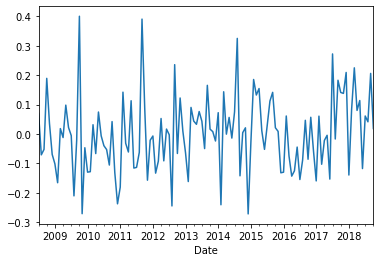

In [30]:
# plot the residuals to see if assumption 5 and 6 hold, namely, that the error term has zero population mean, and the error term is normally
# distributed
reg.resid.plot()
plt.show()
# Looking at this graph alone is hard to tell.

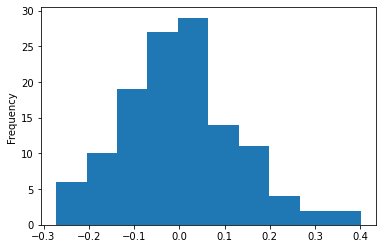

In [31]:
# I will plot a histogram and a qq plot for the residuals
reg.resid.plot(kind='hist')
plt.show()
# Looks like it is a normal distribution

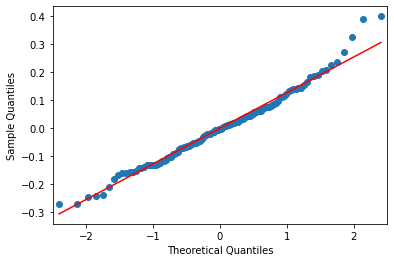

In [32]:
sm.qqplot(reg.resid, line='s')
plt.show()
# Also looks it is a normal distribution

In [33]:
# Run a Kolmogorov-Smirnov test to test for normality
sm.stats.diagnostic.kstest_normal(reg.resid)
# The null hypothesis is that the sample comes from a normal distribution. Our p-value is 0.678, and so we fail to reject the null hypothesis
# and conclude that the residuals are normally distributed

(0.050150393178627795, 0.6779683097389162)

In [34]:
# compute the mean of the residuals to see if it is zero
reg.resid.mean()
# We get a mean very close to zero, and can be said to be practically zero. We conclude that assumptions 5 and 6 do indeed hold.

1.8897070288498835e-14

In [35]:
# When we calculate the variance inflation factors again, we see that the addition of autoregressive terms have brought about a multicollinearity
# problem. This problem, however, only effects the variables that are involved. Our third assumption still holds, as there is no perfect
# multicollinearity between our independent variables. If there were, the regression would not run.
vif = pd.DataFrame()
vif['feature'] = X.columns
vif['VIF'] = ''
vif_list = []
for i in range(len(X.columns)):
    vif_list.append(variance_inflation_factor(X.values,i))
vif['VIF'] = vif_list
vif

,feature,VIF
0,average_temp_diff,1.753113
1,soil_moisture_diff,1.924291
2,precipitation_diff,1.390666
3,working_days_diff,1.073328
4,ha_harvested_diff,1.419124
5,FFB_Yield_shift_1,113.137424
6,FFB_Yield_shift_2,248.026919
7,FFB_Yield_shift_3,239.170774
8,FFB_Yield_shift_4,233.287483
9,FFB_Yield_shift_5,230.895058


In [36]:
# We have concluded that assumptions 2 to 6 hold. How about the first assumption? Conditional mean independence means that there is no
# correlation between the error term and the independent variables, in other words, that there is no omitted variable bias. The independent
# variables will be correlated with the error term if there are variables that are excluded from the model but are correlated with the
# independent variables and the dependent variable. This will cause the coefficients of the model to be biased, meaning that the coefficients
# obtained are not equal to the true coefficients in reality, which will cause us to not to be able to trust our coefficient to give us an
# accurate description of the relationship between the dependent variable and the independent variables. Statistically significant coefficients
# implies that there is correlation between the dependent and independent variables, but this does not imply causation. We are only able to
# conclude causation if the conditional mean independence assumption holds; a necessary condition for concluding causation is unbiasedness.

# Based on my research, I found other variables omitted from my dataset, and which would be correlated with both my independent variables, and
# certainly my dependent variable. They include, but are not limited to: incoming photosynthetically active radiation (PAR), atmospheric CO2
# concentration, planting material, plantation establishment, planting density, canopy management, pollination (and hence the flowering of the
# tree), and presence of pests (Woittiez et al., 2017).

# Conclusion

In [37]:
# Because the conditional mean independence assumption does not hold, I cannot determine the influence that external factors have on the yield
# of oil palm trees in numerical terms. All I can conclude is correlation, not causation. I conclude that the following external factors have a
# statistically significant relationship with the yield of oil palm trees, based on my regression model: the precipitation and the number of
# working days. The other variables, namely, average temperature, soil moisture, and hectares harvested, do not have a statistically significant
# relationship with the fresh fruit bunch yield of oil palm trees.

# References

In [38]:
# Lotte S. Woittiez, Mark T. van Wijk, Maja Slingerland, Meine van Noordwijk, Ken E. Giller, Yield gaps in oil palm: A quantitative review of
# contributing factors, European Journal of Agronomy, Volume 83, 2017, Pages 57-77, ISSN 1161-0301, https://doi.org/10.1016/j.eja.2016.11.002.
# (https://www.sciencedirect.com/science/article/pii/S1161030116302131)